In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy .stats import pearsonr
from scipy.sparse import csr_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


In [3]:
df=pd.read_csv('/Users/debasishguru/Desktop/untitled folder/Next Project Hike 8 /all_upwork_jobs_next.csv')


## Compare average hourly rates across different countries

In [4]:
# Filter out non-hourly jobs
hourly_jobs = df[df['is_hourly'] == True].copy()

# Calculate the average hourly rate
hourly_jobs.loc[:, 'average_hourly_rate'] = hourly_jobs[['hourly_low', 'hourly_high']].mean(axis=1)

# Drop rows with missing country or average hourly rate
hourly_jobs = hourly_jobs.dropna(subset=['country', 'average_hourly_rate'])

# Calculate average hourly rate by country
country_hourly_rates = hourly_jobs.groupby('country')['average_hourly_rate'].mean().reset_index()

# Rename columns for clarity
country_hourly_rates.columns = ['country', 'avg_hourly_rate']

# Define a custom color scale
custom_color_scale = [
    (0.0, "rgb(165,0,38)"),   # Dark red
    (0.2, "rgb(215,48,39)"),  # Red
    (0.4, "rgb(244,109,67)"), # Orange
    (0.6, "rgb(253,174,97)"), # Light orange
    (0.8, "rgb(254,224,144)"),# Yellow
    (1.0, "rgb(255,255,191)") # Light yellow
]

# Create a choropleth map
fig = px.choropleth(
    country_hourly_rates,
    locations="country",
    locationmode='country names',
    color="avg_hourly_rate",
    hover_name="country",
    color_continuous_scale=custom_color_scale,
    title="Average Hourly Rates by Country"
)

# Update layout for better visuals and increased size
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    title=dict(x=0.5),
    width=1200,   # Set the width of the plot
    height=800    # Set the height of the plot
)

fig.show()


In [5]:
# combine title and country into s dnglr column for text processing
df['text']=df['title']+" "+df["country"]
df.head(2)

,Unnamed: 0,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,avg_salary,category,month,year,month_year,text
0,0,experienced media buyer for solar pannel and r...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,17.339644,41.97061,500.0,Unknown,29.655127,Other,2,2024,2024-02,experienced media buyer for solar pannel and r...
1,1,full stack developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,17.339644,41.97061,1100.0,United States,29.655127,Full Stack Developer,2,2024,2024-02,full stack developer United States


## Compare average hourly rates across different countries

In [6]:
# Feature Engineering

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit and transform the text data
tfidf_matrix = tfidf.fit_transform(df['text'])

# Display the shape of the TF-IDF matrix
tfidf_matrix.shape

(244828, 1000)

In [7]:
! pip install faiss-cpu



In [8]:
import faiss
# Combine title and country into a single column fot text processing
df['text']=df['title']+" "+df['country']

# Initialize TF-IDF Vectorizer
tfidf=TfidfVectorizer(stop_words='english',max_features=100)

# Fit and transform the text data
tfidf_matrix=tfidf.fit_transform(df['text']).toarray()

# initalize the Faiss index
d=tfidf_matrix.shape[1]# Dimestion of the vectors
index=faiss.IndexFlatL2(d) # L2 distance index

# Addd vectors to the index
index.add(tfidf_matrix)

def get_recommendation(job_title,n=10):
    # get the index of the job that matches the job title
    idx=df[df['title'].str.contains(job_title,case=False,na=False)].index[0]
    # Get the vector fot the job
    job_vector=tfidf_matrix[idx].reshape(1,-1)
    #Search the index for the most similar vectors
    distance,indices=index.search(job_vector,n)
    # Return the most similar jobs
    return df.iloc[indices[0]][['title','country','link']]

# Test the recommendation function
print(get_recommendation('Full Stack Developer'))

                                                  title        country  \
1                                  full stack developer  United States   
1657  full stack developer (us shifts) - monthly con...  United States   
1966               full-stack developer mentorship role  United States   
2025                          full stack maps developer  United States   
3066                               full stack developer  United States   
4551                               full-stack developer  United States   
7435           full-stack developer with frontend focus  United States   
7438               full stack developer with cro skills  United States   
7610                   senior full stack .net developer  United States   
8596                 java full stack developer with aws  United States   

                                                   link  
1     https://www.upwork.com/jobs/Full-Stack-Develop...  
1657  https://www.upwork.com/jobs/Full-Stack-Develop...  
1966  https

In [9]:
# Ensure that published_date is in datetime format 
df['published_date']=pd.to_datetime(df['published_date'])

# Extract month and year from 'published_date'
df['year_month']=df['published_date'].dt.to_period('M')

/var/folders/w7/pp471v290xqffj0zmygxzr_c0000gn/T/ipykernel_15360/2226854676.py:5: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [10]:
# Group by 'year_month ' to get the count of jobs posting each month
monthly_job_counts=df.groupby('year_month').size().reset_index(name='job_count')

# Convert 'year_month' to string format
monthly_job_counts['year_month']=monthly_job_counts['year_month'].astype(str)

In [11]:
remote_jobs=df[df['title'].str.contains('remote',case=False,na=False)]

# Extract year and month from 'published_date'
remote_jobs['year_month']=remote_jobs['published_date'].dt.to_period('M')

# Group by 'year_month' to get the count of remote job posting each month
monthly_remote_job_counts=remote_jobs.groupby('year_month').size().reset_index(name='job_count')
monthly_remote_job_counts['year_month']=monthly_remote_job_counts['year_month'].astype(str)

/var/folders/w7/pp471v290xqffj0zmygxzr_c0000gn/T/ipykernel_15360/358565646.py:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/var/folders/w7/pp471v290xqffj0zmygxzr_c0000gn/T/ipykernel_15360/358565646.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Forecasting

## Predict future job market trends 


In [12]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

18:30:37 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing


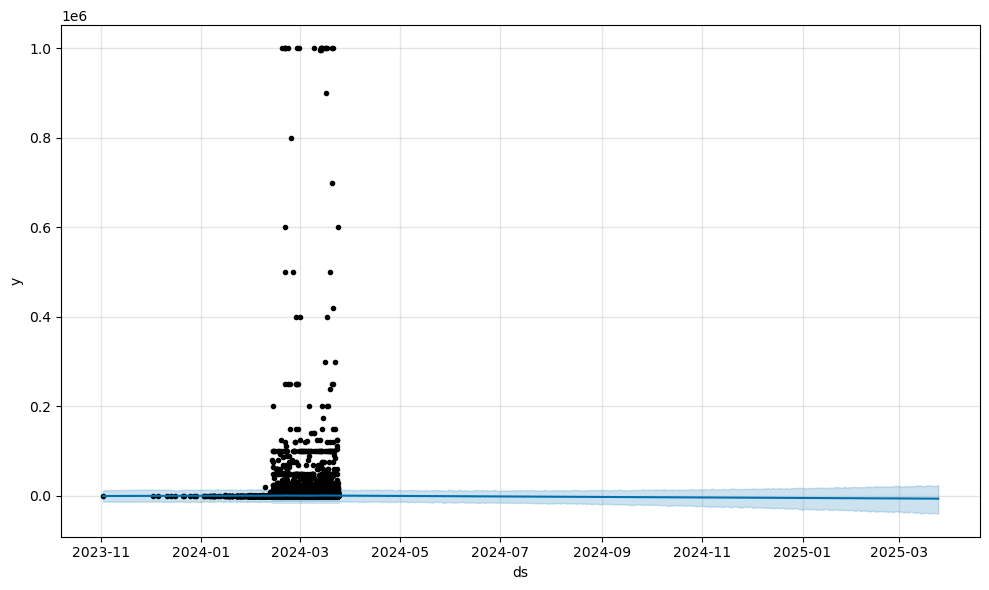

In [13]:
df=pd.read_csv('/Users/debasishguru/Desktop/untitled folder/Next Project Hike 8 /all_upwork_jobs_next.csv')

# Convert the 'pblished_date' column to datetime
df['published_date']=pd.to_datetime(df['published_date'])

# Remove the timezone information from 'published_date' column
df['published_date']=df['published_date'].dt.tz_localize(None)

# Rename columns for Prophet compatibilty
df=df.rename(columns={'published_date':'ds','budget':'y'})

# Create and fit the prophet model
model=Prophet()
model.fit(df)

# nmake future predications
future=model.make_future_dataframe(periods=365)
forecast=model.predict(future)

# plot the forecast
fig=model.plot(forecast)

# show the plot
plt.show()